In [1]:
import numpy as np
import gudhi
import matplotlib.pyplot as plot
import seaborn as sns
import networkx as nx
import plotly.graph_objects as go

In [2]:
def count_strains(labels):
    strain_counts = {}
    strain_colors = {
        'H3N2': 'blue',
        'H1N1': 'orange',
        'H1N2': 'green',
        'H3N1' : 'yellow',
    }
    for label in labels:
        strain = label.split('(')[1].split(')')[0]  # Extrae la cepa entre paréntesis
        strain_counts[strain] = strain_counts.get(strain, 0) + 1
    print("Número de secuencias para la prueba:")
    for strain, count in strain_counts.items():
        color = strain_colors.get(strain, 'gray')
        print(f"{strain} = {count} ({color})")
    return strain_colors

In [3]:
def visualize_simplicial_complex(simplex_tree, filtration_value, vertex_names=None, save_filename=None, plot_size=1000):
    G = nx.Graph()
    triangles = []
    tetrahedra = []
    edges = []
    hole_2d_simplices = []

    # Encontrar el agujero 2D
    persistence_2 = simplex_tree.persistence_intervals_in_dimension(2)
    hole_birth = None
    if len(persistence_2) > 0:
        hole_birth = persistence_2[0][0]  # Asumiendo que solo hay un agujero 2D

    # Procesar cada simplex en el árbol de simplex
    for simplex, filt in simplex_tree.get_filtration():
        if filt <= filtration_value:
            if len(simplex) == 2:
                G.add_edge(simplex[0], simplex[1])
                edges.append(simplex)
            elif len(simplex) == 1:
                G.add_node(simplex[0])
            elif len(simplex) == 3:
                triangles.append(simplex)
                if hole_birth is not None and filt == hole_birth:
                    hole_2d_simplices.append(simplex)
            elif len(simplex) == 4:
                tetrahedra.append(simplex)

    # El resto de la función permanece igual...
    
    # Crear layout del grafo
    pos = nx.spring_layout(G, dim=3)

    # Obtener los colores de las cepas
    strain_colors = count_strains(vertex_names)

    # Crear trazas para nodos
    node_x, node_y, node_z = zip(*[pos[node] for node in G.nodes()])
    node_labels = [vertex_names[node] if vertex_names else str(node) for node in G.nodes()]
    node_colors = [strain_colors.get(label.split('(')[1].split(')')[0], 'gray') for label in node_labels]
    node_trace = go.Scatter3d(x=node_x, y=node_y, z=node_z, mode='markers+text', 
                              marker=dict(size=5, color=node_colors),
                              text=node_labels, textposition="top center", 
                              hoverinfo='text')

    # Crear trazas para aristas
    edge_x, edge_y, edge_z = [], [], []
    edge_colors = []
    for edge in G.edges():
        x0, y0, z0 = pos[edge[0]]
        x1, y1, z1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
        edge_z.extend([z0, z1, None])
        # Comprobar si esta arista es parte del agujero 2D
        is_hole_edge = any(set(edge).issubset(triangle) for triangle in hole_2d_simplices)
        edge_colors.extend(['yellow' if is_hole_edge else 'black'] * 3)
    edge_trace = go.Scatter3d(x=edge_x, y=edge_y, z=edge_z, mode='lines', 
                              line=dict(width=2, color=edge_colors), hoverinfo='none')

    # Crear trazas para triángulos
    triangle_traces = []
    for triangle in triangles:
        x = [pos[v][0] for v in triangle]
        y = [pos[v][1] for v in triangle]
        z = [pos[v][2] for v in triangle]
        color = 'yellow' if triangle in hole_2d_simplices else 'red'
        opacity = 0.7 if triangle in hole_2d_simplices else 0.3
        triangle_trace = go.Mesh3d(x=x, y=y, z=z, opacity=opacity, color=color)
        triangle_traces.append(triangle_trace)

    # Crear trazas para tetraedros
    tetrahedra_traces = []
    for tetrahedron in tetrahedra:
        x = [pos[v][0] for v in tetrahedron]
        y = [pos[v][1] for v in tetrahedron]
        z = [pos[v][2] for v in tetrahedron]
        tetrahedron_trace = go.Mesh3d(x=x, y=y, z=z, opacity=0.1, color='green')
        tetrahedra_traces.append(tetrahedron_trace)

    # Configurar el layout
    layout = go.Layout(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        ),
        margin=dict(r=0, l=0, b=0, t=0),
        showlegend=False
    )

    # Crear la figura y añadir las trazas
    fig = go.Figure(data=[node_trace, edge_trace] + triangle_traces + tetrahedra_traces, layout=layout)

    fig.update_layout(width=plot_size, height=plot_size)

    if save_filename:
        fig.write_image(save_filename, width=plot_size, height=plot_size, scale=1)

    fig.show()

    return G

In [28]:
sG3 = np.array([
    [  0.,   9., 136.,  53., 129.],
    [  9.,   0., 137.,  55., 130.],
    [136., 137.,   0., 114.,  11.],
    [ 53.,  55., 114.,   0., 111.],
    [129., 130.,  11., 111.,   0.],
])





# Convertir la lista a una matriz NumPy
sG3 = np.array(sG3)

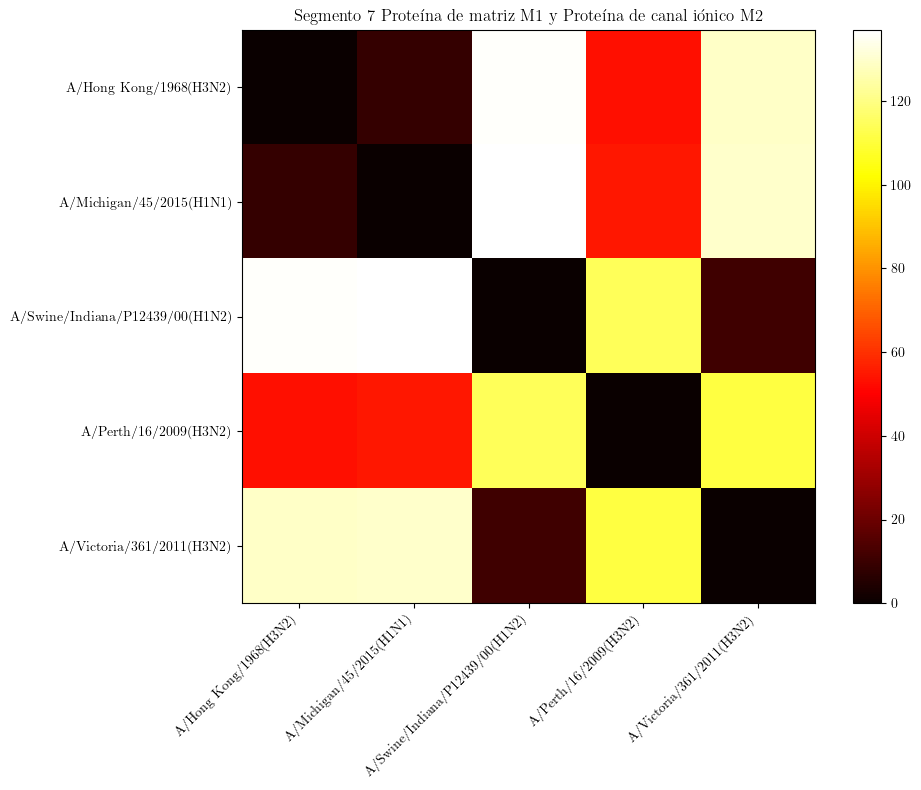

In [30]:
# Definir las etiquetas para las columnas y filas
labels = [
    'A/Victoria/361/2011(H3N2)',
    'A/Perth/16/2009(H3N2)',
    'A/Michigan/45/2015(H1N1)',
    'A/California/07/2009(H1N1)'
]

# Crear la figura del mapa de calor
fig, ax = plot.subplots(1, 1, figsize=(10, 8))
im = ax.imshow(sG3, cmap='hot')
ax.set_title('Segmento 7 Proteína de matriz M1 y Proteína de canal iónico M2')
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_yticklabels(labels)
cbar = fig.colorbar(im, ax=ax)
plot.tight_layout()
plot.show()

In [32]:
max_edge_length = 2300
max_dimension = 5
band = 0.0

print("#####################################################################")
print("RipsComplex creation from defined distance matrix G3")

#####################################################################
RipsComplex creation from defined distance matrix G3


In [34]:
# Crear el complejo de Rips
rips_complex = gudhi.RipsComplex(distance_matrix=sG3, max_edge_length=max_edge_length)

# Crear el árbol de simplex
simplex_tree = rips_complex.create_simplex_tree(max_dimension=max_dimension)

message = "Number of simplices=" + repr(simplex_tree.num_simplices()) 
print(message)

# Calcular la persistencia
diag = simplex_tree.persistence()

print("betti_numbers()=")
print(simplex_tree.betti_numbers())

Number of simplices=31
betti_numbers()=
[1, 0, 0, 0]


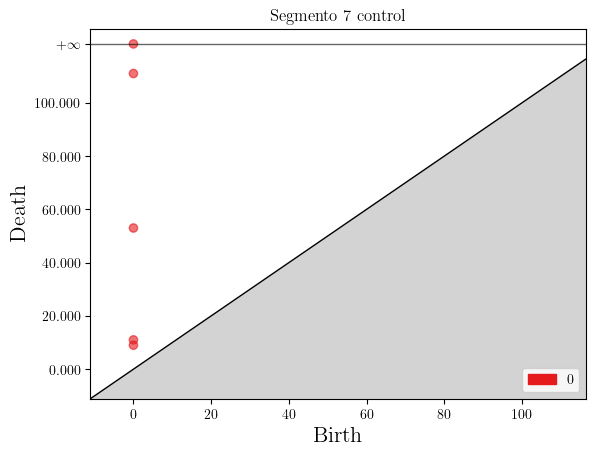

In [36]:
gudhi.plot_persistence_diagram(diag, band=band)
plot.title("Segmento 7 control") 
plot.savefig("Segmento 7 control.png", dpi=300, bbox_inches='tight')
plot.show()

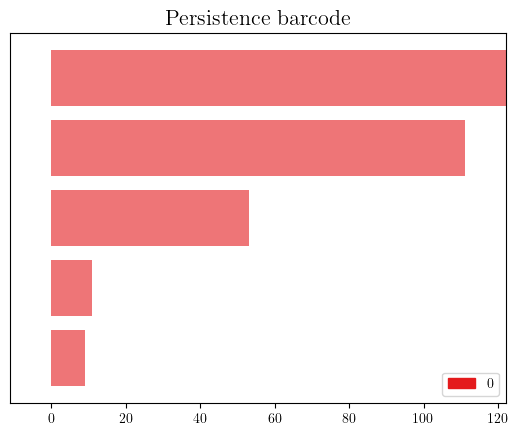

In [38]:
gudhi.plot_persistence_barcode(diag)
plot.show()

Visualizing 3D simplicial complex at filtration time 150
Número de secuencias para la prueba:
H3N2 = 3 (blue)
H1N1 = 1 (orange)
H1N2 = 1 (green)


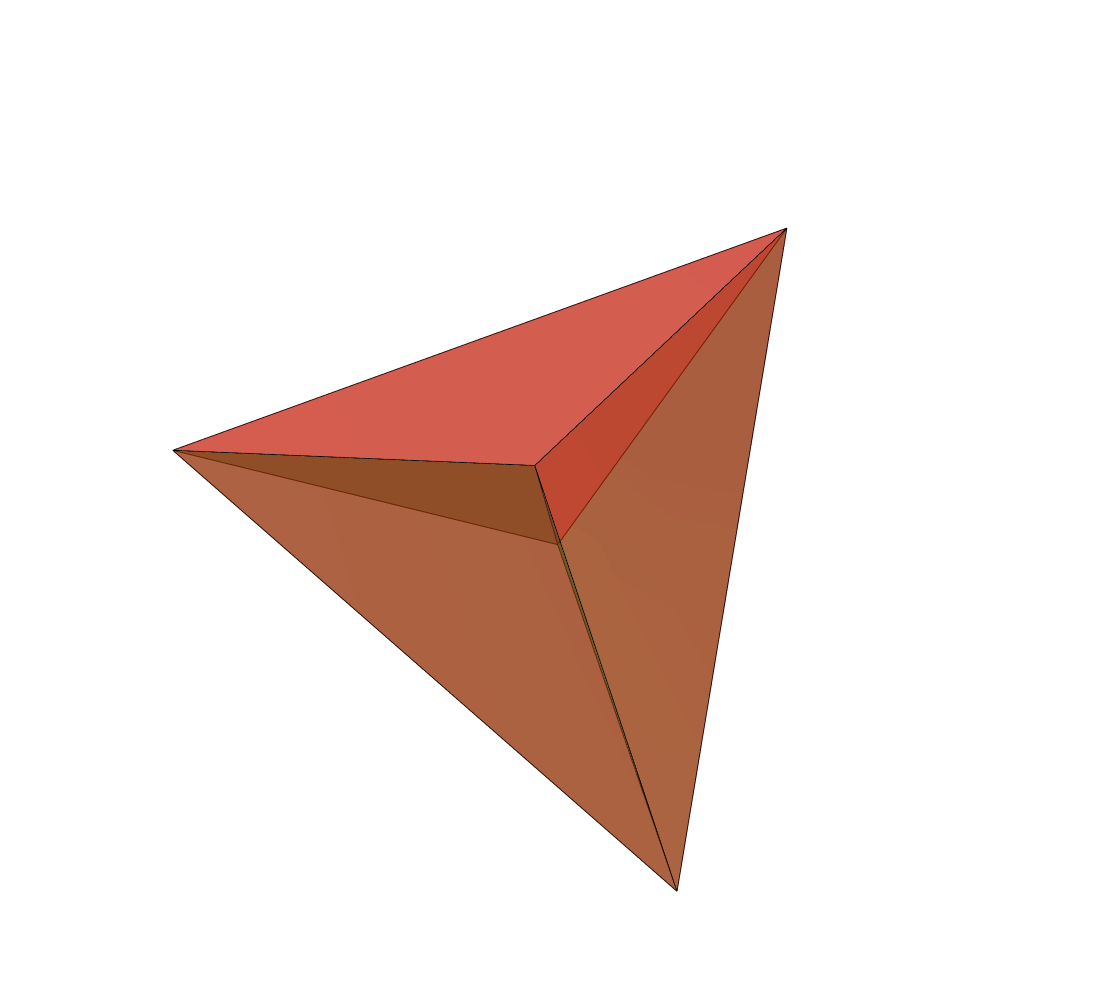

In [40]:
# Visualizar el complejo simplicial 3D
print("Visualizing 3D simplicial complex at filtration time 150")
visualize_simplicial_complex(simplex_tree, 150, vertex_names=labels)